<a href="https://colab.research.google.com/github/ashish244co/SHALA2020/blob/master/Ashish_Kashav_assignment_segmentation_SHALA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
import os

DATA_DIR = './data/CamVid/'

if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')
    
CLASS_NAMES = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabelled']

CLASS_COLORS = [(128, 128, 128), (128, 0, 0), (192, 192, 128), (128, 64, 128), (0, 0, 192),
                (128, 128, 0), (192, 128, 128), (64, 64, 128), (64, 0, 128),
                (64, 64, 0), (0, 128, 192), (0, 0, 0)]

In [3]:
!pip install -U catalyst

Requirement already up-to-date: catalyst in /usr/local/lib/python3.6/dist-packages (20.6)


In [0]:
import os
from collections import OrderedDict
from functools import partial
import numpy as np
import torch
import torch.nn as nn
import cv2
from torch.optim import Adam, SGD, ASGD, RMSprop, LBFGS
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.models import resnet34
from datetime import datetime

In [0]:
import torchvision

In [6]:
! pip install --quiet git+https://github.com/albu/albumentations

In [0]:
import albumentations as A

In [0]:
class CamVidDataset(Dataset):


    def __init__(
            self,
            images_dir,
            masks_dir,
            transform=A.Normalize()
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.transform = transform


    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        mask = cv2.imread(self.masks_fps[i],cv2.IMREAD_GRAYSCALE)
        
        # apply augmentations

        

        sample = self.transform(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
        image = np.moveaxis(image, -1, 0)
        image = np.ascontiguousarray(image)
        image = torch.from_numpy(image)

        return {
            "features": image,
            "targets": torch.from_numpy(mask).long()
        }

    def __len__(self):
        return len(self.ids)

In [0]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [0]:
def get_training_augmentation(blur=True, weather=True):
    return A.Compose([
        A.PadIfNeeded(384, 384, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=11),
        A.Normalize()
    ])


def get_validation_augmentation():
    return A.Compose([
        A.PadIfNeeded(384, 384, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=11),
        A.Normalize()
    ])

In [11]:
train_ds = CamVidDataset(x_train_dir, y_train_dir, transform=get_training_augmentation())
valid_ds = CamVidDataset(x_valid_dir, y_valid_dir, transform=get_validation_augmentation())

print('Train dataset size', len(train_ds))
print('Valid dataset size', len(valid_ds))

Train dataset size 367
Valid dataset size 101


In [0]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


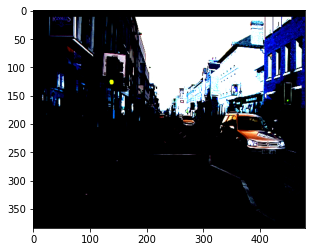

In [13]:
plt.imshow(np.transpose(train_ds[1]['features'].cpu().detach().numpy(), (1, 2, 0)))

In [14]:
np.transpose(train_ds[1]['features'].cpu().detach().numpy(), (1, 2, 0)).shape

(384, 480, 3)

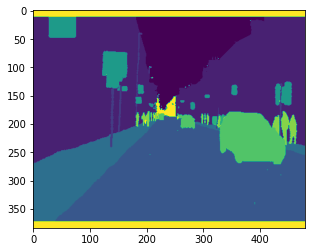

In [15]:
plt.imshow(train_ds[1]['targets'])

In [0]:
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor, smooth=0, eps=1e-7, dims=None) -> torch.Tensor:
   
    if dims is not None:
        intersection = torch.sum(y_pred * y_true, dim=dims)
        cardinality = torch.sum(y_pred + y_true, dim=dims)
    else:
        intersection = torch.sum(y_pred * y_true)
        cardinality = torch.sum(y_pred + y_true)
    dice_score = (2.0 * intersection) / (cardinality+ eps)
    return dice_score

In [17]:
A.PadIfNeeded(384, 384, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=11)

PadIfNeeded(always_apply=False, p=1.0, min_height=384, min_width=384, border_mode=0, value=0, mask_value=11)

In [18]:
(360, 480, 3)

(360, 480, 3)

In [0]:
class DecoderBlockLinkNet(nn.Module):
    def __init__(self, in_channels, n_filters):
        super().__init__()

        self.relu = nn.ReLU(inplace=True)

        # B, C, H, W -> B, C/4, H, W
        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)

        # B, C/4, H, W -> B, C/4, 2 * H, 2 * W
        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,stride=2, padding=1, output_padding=0)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)

        # B, C/4, H, W -> B, C, H, W
        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu(x)
        return x


class LinkNet34(nn.Module):
    def __init__(self, num_classes=1, num_channels=3, pretrained=True):
        super().__init__()
        self.num_classes = num_classes
        resnet = resnet34(pretrained=pretrained)

        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        # Decoder

        self.decoder4 = DecoderBlockLinkNet(512, 256)
        self.decoder3 = DecoderBlockLinkNet(256, 128)
        self.decoder2 = DecoderBlockLinkNet(128, 64)
        self.decoder1 = DecoderBlockLinkNet(64,64)

        # Final Classifier
        self.finaldeconv1 = nn.ConvTranspose2d(64, 32, 3, stride=2)
        self.finalrelu1 = nn.ReLU(inplace=True)
        self.finalconv2 = nn.Conv2d(32, 32, 3)
        self.finalrelu2 = nn.ReLU(inplace=True)
        self.finalconv3 = nn.Conv2d(32, num_classes, 2, padding=1)

    def forward(self, x):
      
        # Encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        # Decoder with Skip Connections

        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)


        # Final Classification
        f1 = self.finaldeconv1(d1)
        f2 = self.finalrelu1(f1)
        f3 = self.finalconv2(f2)
        f4 = self.finalrelu2(f3)
        f5 = self.finalconv3(f4)


        
        return f5 



In [0]:
num_classes = len(CLASS_NAMES)

In [0]:
net=LinkNet34(num_classes).cuda()

In [22]:
net.firstconv.requires_grad_(False)
net.encoder1.requires_grad_(False)
net.encoder2.requires_grad_(False)
net.encoder3.requires_grad_(False)
net.encoder4.requires_grad_(False)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [0]:
loss_fn = nn.CrossEntropyLoss()
opt = Adam(net.parameters(),weight_decay=1e-4)

In [0]:
data_loaders = {}
data_loaders['train'] = DataLoader(train_ds, batch_size=16, pin_memory=True)
data_loaders['valid'] = DataLoader(valid_ds, batch_size=16, pin_memory=True)

In [0]:
dataloader_iterator = iter(data_loaders['train'])

In [26]:
next(dataloader_iterator)['features'].shape[0]

16

In [27]:
from catalyst.dl import SupervisedRunner

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



In [28]:
runner = SupervisedRunner()
runner.train(
    model=net,
    criterion=loss_fn,
    optimizer=opt,
    loaders=data_loaders,
    num_epochs=5,
    verbose=False
)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning:

This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha)



[2020-06-13 20:30:13,820] 
1/5 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/5 * Epoch 1 (train): loss=2.0026
1/5 * Epoch 1 (valid): loss=2.0232
[2020-06-13 20:30:49,058] 
2/5 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/5 * Epoch 2 (train): loss=1.0693
2/5 * Epoch 2 (valid): loss=1.0559
[2020-06-13 20:31:24,226] 
3/5 * Epoch 3 (_base): lr=0.0010 | momentum=0.9000
3/5 * Epoch 3 (train): loss=0.7025
3/5 * Epoch 3 (valid): loss=0.7201
[2020-06-13 20:31:59,430] 
4/5 * Epoch 4 (_base): lr=0.0010 | momentum=0.9000
4/5 * Epoch 4 (train): loss=0.5764
4/5 * Epoch 4 (valid): loss=0.6884
[2020-06-13 20:32:34,501] 
5/5 * Epoch 5 (_base): lr=0.0010 | momentum=0.9000
5/5 * Epoch 5 (train): loss=0.5059
5/5 * Epoch 5 (valid): loss=0.6311


In [29]:
net.firstconv.requires_grad_(True)
net.encoder1.requires_grad_(True)
net.encoder2.requires_grad_(True)
net.encoder3.requires_grad_(True)
net.encoder4.requires_grad_(True)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [30]:
runner.train(
    model=net,
    criterion=loss_fn,
    optimizer=opt,
    loaders=data_loaders,
    num_epochs=5,
    verbose=False
)

[2020-06-13 20:33:13,757] 
1/5 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/5 * Epoch 1 (train): loss=0.8186
1/5 * Epoch 1 (valid): loss=0.8546
[2020-06-13 20:33:53,018] 
2/5 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/5 * Epoch 2 (train): loss=0.5089
2/5 * Epoch 2 (valid): loss=0.5651
[2020-06-13 20:34:32,240] 
3/5 * Epoch 3 (_base): lr=0.0010 | momentum=0.9000
3/5 * Epoch 3 (train): loss=0.4281
3/5 * Epoch 3 (valid): loss=0.4626
[2020-06-13 20:35:11,477] 
4/5 * Epoch 4 (_base): lr=0.0010 | momentum=0.9000
4/5 * Epoch 4 (train): loss=0.3835
4/5 * Epoch 4 (valid): loss=0.4373
[2020-06-13 20:35:50,773] 
5/5 * Epoch 5 (_base): lr=0.0010 | momentum=0.9000
5/5 * Epoch 5 (train): loss=0.3534
5/5 * Epoch 5 (valid): loss=0.3927


In [31]:
valid_ds[10]['features'].size()

torch.Size([3, 384, 480])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


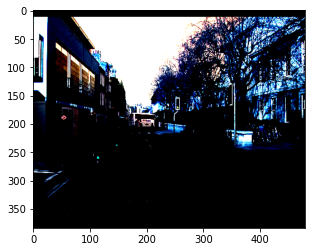

In [32]:
plt.imshow(np.transpose((valid_ds[19]['features']).cpu().detach().numpy(), (1, 2, 0)))

In [0]:
pred=net(valid_ds[19]['features'].cuda().view(1,3,384,480))

In [34]:
torch.argmax(pred, dim=1).size()

torch.Size([1, 384, 480])

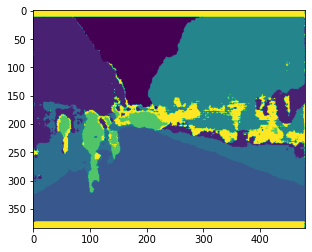

In [35]:
plt.imshow(torch.argmax(pred, dim=1).cpu().detach().numpy().reshape(384, 480))